# LV3 Recovery Test

This notebook will encompass all calculations regarding the LV3 Recovery/eNSR Drop Test.

Resources
-------
[http://www.usma.edu/math/Military%20Math%20Modeling/C5.pdf]  
[http://www.the-rocketman.com/drogue-decent-rate.html]

## setup

### imports

In [1]:
import math
import sympy
from sympy import Symbol, solve
from scipy.integrate import odeint
from types import SimpleNamespace
import numpy as np
import matplotlib.pyplot as plt
sympy.init_printing()
%matplotlib inline

### input parameters

In [2]:
# General variables

# mass of payload [kg]
m = 28
# g = acceleration due to gravity [kg*m/s^2]
g = 9.81
# P = speed of plane [m/s]
P = 38

## Calculations

### Step a - static line extending

#### Assumptions:
* no drag
* static line is approximately 2m long
* plane is flying at approximately 85 mph = 38 m/s

#### Variables
* va = vertical velocity at instant the system is pushed from the plane [m/s]
* sl = static line length [m]
* Lva = vertical length gained from step a [m]
* Lha = horizontal length gained from step a [m]
* ta = time for step a to be complete [s]

#### calculations

In [3]:
va = 0
sl = 2

## vertical distance gained
## since the static line is 2m, assuming it falls only in the vertical direction:
Lva = 2

# horizontal distance gained
## speed of plane times time to drop 2m static line
## 1/2*g*ta**2 = sl
ta = math.sqrt(2*sl/g)
Lha = P*ta

print('step a (from drop to static line disconnect):')
print('time to free fall fall 2 m = ', round(ta,4), ' s')
print('vertical length gained = ', round(Lva,4), ' m')
print('horizontal length gained = ', round(Lha,4), ' m')

step a (from drop to static line disconnect):
time to free fall fall 2 m =  0.6386  s
vertical length gained =  2  m
horizontal length gained =  24.2649  m


### Step b - deployment timer running

 deployment timer is a 2 sec timer
#### Assumptions
* neglecting drag force

#### Variables
* P = speed of plane
* vb = velocity after 2m static line has extended (aka instant static line 'snaps')
* g = acceleration due to gravity
* Lvb = vertical length gained from step b
* Lhb = horizontal length gained from step b
* tb = time for step b to be complete

#### calculations

In [4]:
# vertical velocity at end of static line, beginning of timer
vb = va + (g*ta)

# since the deployment is controlled by a 2 sec timer:
tb = 2

# vertical length gained
Lvb = (vb*tb) + (0.5*g*(tb**2))

# horizontal length gained
Lhb = P*tb

print('step b (from static line disconnect to timer runout):')
print('vertical velocity at beginning of step b = ', round(vb,4), ' m/s')
print('vertical length gained = ', round(Lvb,4), ' m')
print('horizontal length gained = ', round(Lhb,4), ' m')

step b (from static line disconnect to timer runout):
vertical velocity at beginning of step b =  6.2642  m/s
vertical length gained =  32.1484  m
horizontal length gained =  76  m


### Step c - eNSR ring separation

#### Assumptions:
* This step only lasts for an instant; i.e. has no duration
* drogue timer begins as ring separation occurs

#### Variables
* P = speed of plane
* vc = velocity at time of ring separation
* g = acceleration due to gravity
* Lvc = vertical length gained from step c
* Lhc = horizontal length gained from step c
* tc = time for step c to be complete

#### calculations

In [5]:
# velocity at time of ring separation, end of timer
vc = vb + g*tb

Lhc = 0
Lvc = 0

print('vertical velocity at ring separation = ', round(vc,4), ' m/s')

vertical velocity at ring separation =  25.8842  m/s


### Step d - drogue line is being pulled out

#### Assumptions
* no drag force considered for horizon. and vert. decent until drogue is fully unfurled
* just accounting for the 50' shock chord, therefore not including the lines coming directly from the 'chute
* the drogue pulls out at an angle due to a small amount of drag on the drogue slowing it down horizontally

#### Variables
* P = speed of plane
* vd = velocity after 50' shock chord is drawn out
* g = acceleration due to gravity
* Lvd = vertical distance gained from step d
* Lhd = horizontal distance gained from step d
* td = time for step d to be complete

 the 50' chord as the hypotenuse  
$50 = \sqrt{(x^2) + (y^2)}$

vertical length gained from step d  
$Lvd = vc*td + 0.5*g*(td^2)$

horizontal length gained from step d  
$Lhd = P*td$

calculate td by replacing x and y in the above equation  
$50^2 = (P*td)^2 + (vc*td + g*td^2)^2$

#### calculations

In [6]:
Ps, vds, gs, Lvds, Lhds, tds, vcs = sympy.symbols('Ps vds gs Lvds Lhds tds vcs')
Dparms= {Ps: 50, gs: 9.81, vcs: vc}
tdEqn= (Ps*tds)**2 + (vcs*tds + 0.5*gs*tds**2)**2 - 50**2
tdSolns= sympy.solve(tdEqn.subs(Dparms))
print('possible solutions:', tdSolns)
for soln in [complex(x) for x in tdSolns]:
    if (soln.imag != 0) or (soln.real <= 0):
        pass
    else:
        print(soln, 'seems fine')
        td= soln.real

# now go back and calculate x and y
Lhd = P*td
Lvd = vc*td + g*(td**2)
# vertical velocity gained after the 50' drop
vd = vc + g*td

print()
print('time to pull out drogue:', round(td,4), 's')
print('horizontal distance gained = ', round(Lhd,4), 'm')
print('vertical distance gained = ', round(Lvd,4), 'm')
print('vertical velocity at instant line becomes taught = ', round(vd,4), 'm/s')
print('horizontal velocity: ', P, 'm/s')

possible solutions: [-0.919508022756004, 0.856834792225604, -5.245765098363 - 10.2162218889171*I, -5.245765098363 + 10.2162218889171*I]
(0.856834792225604+0j) seems fine

time to pull out drogue: 0.8568 s
horizontal distance gained =  32.5597 m
vertical distance gained =  29.3806 m
vertical velocity at instant line becomes taught =  34.2897 m/s
horizontal velocity:  38 m/s


### Step e - drogue is fully deployed

#### Assumptions
* drag force in full effect
* skipping impulse and time to steady state

#### Variables
* cd = coeff. of drag [unitless]
* D = drag force = mass of payload*g [N]
* rho = density of air [kg/m^3]
* A = area of parachute [m^2]
* v = approx. steady state velocity of drogue [m/s]
* m = mass of payload [kg]
* Rd = drogue radius [m]
* w = wind speed [m/s]

#### numerical solution

In [7]:
D = m*g
v = 18.5 # according to rocketman
rho = 1.2
R_d= 0.762
A_d = math.pi*(R_d**2)
cd = (2*D)/(rho*A_d*v**2)
m = 28
w = 12.86

# bundle up the parameters needed by dragFunc():
p= SimpleNamespace()
p.rho= rho
p.A= A_d
p.Cd= cd
p.m= m
p.g= g
p.wx= -w

In [8]:
# m*rddot_x +1/2*rho*A*Cd*sqrt(rdot_x**2+rdot_y**2)*rdot_x =0
# m*rddot_y +1/2*rho*A*Cd*sqrt(rdot_x**2+rdot_y**2)*rdot_y +m*g =0
def dragFunc(y, t0, p):
    r_x=     y[0]
    r_y=     y[1]
    rdot_x=  y[2]
    rdot_y=  y[3]
    # rddot_x= 1/p.m*(-1/2*p.rho*p.A*p.Cd*np.sqrt((rdot_x)**2+rdot_y**2)*(rdot_x-p.wx))
    # rddot_y= 1/p.m*(-1/2*p.rho*p.A*p.Cd*np.sqrt((rdot_x)**2+rdot_y**2)*rdot_y -p.m*p.g)
    rddot_x= 1/p.m*(-1/2*p.rho*p.A*p.Cd*np.sqrt((rdot_x-p.wx)**2+rdot_y**2)*(rdot_x-p.wx))
    rddot_y= 1/p.m*(-1/2*p.rho*p.A*p.Cd*np.sqrt((rdot_x-p.wx)**2+rdot_y**2)*rdot_y -p.m*p.g)
    return([rdot_x, rdot_y, rddot_x, rddot_y])

# set the boundary conditions for the solver:
y0= [0, 0, P, -vd]
t_step= 0.001
t_start= 0
t_final= 8
times= np.linspace(t_start, t_final, (t_final-t_start)/t_step)
# run the simulation:
soln= odeint(func= dragFunc, y0= y0, t= times, args= (p,))

# find the time when it's okay to deploy the main chute:
soln_yddot= np.diff([s[3] for s in soln]) # y acceleration
soln_xddot= np.diff([s[2] for s in soln]) # x acceleration
for i in range(0, len(soln)):
    if (soln_xddot[i] < 0.01*soln_xddot[0]) and (soln_yddot[i] < 0.01*soln_yddot[0]):
        print('At time', round(times[i],4), 'x and y acceleration are below 1% their original values.')
        t_cr= times[i]
        break

# chop of the stuff after the critical time:
#soln= soln[range(0,i)]
#times= times[range(0,i)]

At time 1.6262 x and y acceleration are below 1% their original values.


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:19: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


#### plots

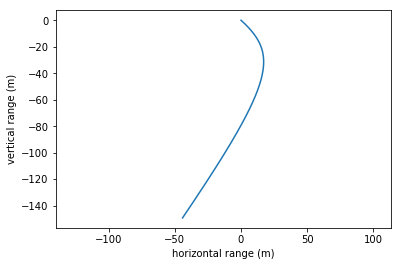

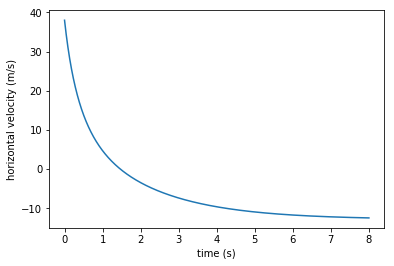

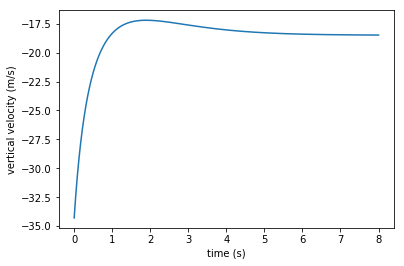

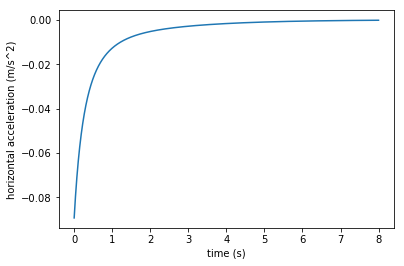

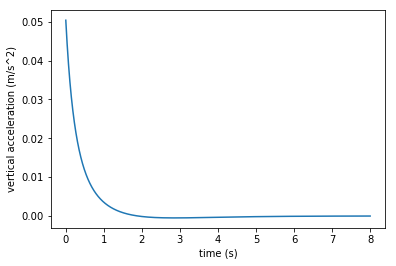

In [9]:
# break out the solutions into convenient names:
soln_x= [s[0] for s in soln]
soln_y= [s[1] for s in soln]
soln_xdot= [s[2] for s in soln]
soln_ydot= [s[3] for s in soln]

# plot dat shit:
plt.figure(1)
plt.plot(soln_x, soln_y)
plt.axis('equal')
plt.xlabel('horizontal range (m)')
plt.ylabel('vertical range (m)')
plt.figure(2)
plt.plot(times, soln_xdot)
plt.xlabel('time (s)')
plt.ylabel('horizontal velocity (m/s)')
plt.figure(3)
plt.plot(times, soln_ydot)
plt.xlabel('time (s)')
plt.ylabel('vertical velocity (m/s)')
plt.figure(4)
plt.plot(times[range(0, len(soln_xddot))], soln_xddot)
plt.xlabel('time (s)')
plt.ylabel('horizontal acceleration (m/s^2)')
plt.figure(5)
plt.plot(times[range(0, len(soln_yddot))], soln_yddot)
plt.xlabel('time (s)')
plt.ylabel('vertical acceleration (m/s^2)')

#### old calculations

In [10]:
# x-direction calculations
##########################

# from usma:
# mx" + cd*x' = cd*w
####### need python help here #######
# ugh, I have to go learn how to use scipy... 1 sec -- Joe
# mx" + cd*x

## homogeneous equation mx" + rho*x' = 0 
##  characteristic equation for the homogeneous differential equation is:
## mr^2 + rho*r = 0 
## where the roots are: 
## r1 = 0, r2 = -(rho/m)
## complementary solution:
## xc = C1*e^0 + C2* e^(-(rho*t/m))

## non-homogeneous equation mx" + rho*x' = rho*w
## complete solution x = C1 + C2*e^(-(rho*t/m)) + wt

## solving for C1 and C2 using results from step d as initial conditions
## except time = 0 since we are making calculations just for this step
## i.e. x(0) = x_curr_tot and vx(0) = P
## therefore C1 =  and C2 =

# x_0 = Lha + Lhb + Lhc + Lhd
# t = 0
# vx_0 = P
# C1 = Symbol('C1')
# C2 = Symbol('C2')
# C_1 = solve(C1 + C2*math.exp(-(rho*t/m)) + w*t - x_0, C1)
# C_1

# print(C_1)
# C_2 = solve(C2*(-(rho/m)) + w - vx_0, C2)
# print(C_2)
# ## NEEEED HELLLPPP should be using piecewise to solve this
# ## copying C_1 output from just above with the C_2 value
# calc_C1 = 147.560492558936 + 586.6
# print(calc_C1)
# 
# ## therefore the complete solution is: 
# ## x = 734.1605 - 586.6*exp(-(rho*t/m)) + w*t
# 
# ## if the drogue falls for 3 seconds, then
# t = 3
# Lhe = 734.1605 - 586.6*math.exp(-(rho*t/m)) + w*t
# 
# print('horizontal distance gained = ', round(Lhe,4), 'm')
# print(' ')
# 
# # y-direction calculations
# ##########################
# 
# ## from usma
# ## characteristic equation:
# ## m*r^2 + rho*r = 0
# ## where the roots are r = 0 and r = (-b/m)
# 
# ## complete solution:
# ## y = C1 + C2*exp(-(rho*t)/m)
# ## solving for C1 and C2 using results from step d as initial conditions
# ## except time = 0 since we are making calculations just for this step
# 
# y_0 = Lva + Lvb + Lvc + Lvd
# print('y_0 = ', y_0)
# vy_0 = vd
# print('vy_0 = ',vy_0)
# t_0 = 0
# C1 = Symbol('C1')
# C2 = Symbol('C2')
# ## NEEEED HELLLPPP should be using piecewise to solve this
# # C1 equation
# C_1 = solve(C1 + C2*math.exp(-(rho*t_0/m)) - y_0, C1)
# print('C1 equation: ', C_1)
# # C2 equation/value
# C_2 = solve(C2*(-(rho/m)*math.exp(-(rho*t_0/m))) - vy_0, C2)
# print('C2 = ', C_2)
# ## copying C_1 output from just above with the C_2 value
# calc_C1 = 793.253769802079 + 62.2619406518579                   #62.2619406518579 + (0.879350749407306*793.253769802079)
# print('C1 = ', calc_C1)
# 
# # NEED HELP: need to make C_2 a number (int, float)
# ## if the drogue falls for 3 seconds, then
# t = 3
# Lve = calc_C1 + (-793.253769802079*math.exp(-(rho/m)*t))
# 
# print('vertical distance gained = ', Lve, 'm')
# 
# ## Maayybbbeee
# 
# vert_length = v*t
# print(vert_length)

### Step f - main 'chute fully deployed

#### Assumptions
* drag force in full effect
* skipping impulse and time to steady state
* main 'chute is a full 18' in dia.
* after payload has gone through the drogue decent, the horizontal velocity is the same as the wind speed

* cd = coeff. of drag [unitless]
* D = drag force = weight of payload*g [N]
* rho = density of air [kg/m^3]
* A = area of parachute [m^2]
* v_main = approx. steady state velocity of main 'chute [m/s]
* m = mass of payload [kg]
* w = wind speed [m/s]

#### calculations

In [11]:
v_main = 4.83108 # according to rocketman
rho = 1.2
A = math.pi*(5.4864**2)
m = 28
D = m*g
cd = (2*D)/(rho*A*v)
w = 12.86
Lvf = 304.8

# x-direction calculations
##########################

# from usma:
# mx" + cd*x' = cd*w
####### need python help here #######

## homogeneous equation mx" + rho*x' = 0 
## characteristic equation for the homogeneous differential equation is:
## mr^2 + rho*r = 0 
## where the roots are: 
## r1 = 0, r2 = -(rho/m)
## complementary solution:
## xc = C1*e^0 + C2* e^(-(rho*t/m))

## non-homogeneous equation mx" + rho*x' = rho*w
## complete solution x = C1 + C2*e^(-(rho*t/m)) + wt

## solving for C1 and C2 using results from step d as initial conditions
## except time = 0 since we are making calculations just for this step
## i.e. x(0) = x_curr_tot and vx(0) = P
## therefore C1 =  and C2 =

x_0 = Lha + Lhb + Lhc + Lhd + Lhe
t = 0
vx_0 = w
C1 = Symbol('C1')
C2 = Symbol('C2')
C_1 = solve(C1 + C2*math.exp(-(rho*t/m)) + w*t - x_0, C1)
print(C_1)
C_2 = solve(C2*(-(rho/m)) + w - vx_0, C2)
print(C_2)
## NEEEED HELLLPPP should be using piecewise to solve this
## copying C_1 output from just above with the C_2 value
calc_C1 = 0 + 472.565722165574
print(calc_C1)

## therefore the complete solution is: 
## x = 472.565722165574 - 0 + w*t

## time for the main to drop approximately 1000ft = 304.8m
d = Lvf
t = Lvf/v
Lhf = 472.565722165574 + w*t

print('horizontal distance gained = ', Lhf, 'm')

# y-direction calculations
##########################

## from usma
## characteristic equation:
## m*r^2 + rho*r = 0
## where the roots are r = 0 and r = (-b/m)

## completed solution:
## y = C1 + C2*exp(-(rho*t)/m)
## solving for C1 and C2 using results from step d as initial conditions
## except time = 0 since we are making calculations just for this step

y_0 = Lva + Lvb + Lvc + Lvd + Lve
print('current y decent length ', y_0)
y_f = y_0 + Lvf
v_f = 4.831

C_1 = ((v_f*m)/rho) + 1928.03
C_2 = 1623.23 - C_1





#vy_0 = v_drogue
##C1 = Symbol('C1')
##C2 = Symbol('C2')
## NEEEED HELLLPPP should be using piecewise to solve this
##C_1 = solve(C1 + C2*math.exp(-(rho*t/m)) - y_0, C1)
print('C1 = ', C_1)
#C_2 = solve(C2*(-(rho/m)) - vy_0, C2)
print('C2 = ', C_2)
## copying C_1 output from just above with the C_2 value
##calc_C1 = (0.0669425369539634*431.666666666667) + 1558.70743507288
#print(calc_C1)

##Lvf = 1587.6042968580075 +  (431.666666666667*math.exp(-(rho/m)*t))

print('vertical distance gained = ', Lvf, 'm')

NameError: name 'Lhe' is not defined

In [ ]:
## TOTALLLLSSSSS!!!!!!!!!!!!!!!!1111111111111111!!!!!!!!!!!!

# TOTAL HORIZONTAL DISTANCE TRAVELED
X_TOT = Lha + Lhb + Lhc + Lhd + Lhe + Lhf
print('TOTAL HORIZONTAL DISTANCE TRAVELED', X_TOT, 'm')

# TOTAL VERTICAL DISTANCE DESCENDED
Y_TOT = Lva + Lvb + Lvc + Lvd + Lve + Lvf
print('TOTAL VERTICAL DISTANCE DESCENDED', Y_TOT, 'm')